## Python notebook: Analysis of Tutorial Reentrant Channel Output

We require standard python packages ``numpy`` and ``matplotlib``,
and use package ``MITgcmutils`` (as described in chapter 11 of the MITgcm users guide)
to load model grid and diagnostic output data (in binary format). Users should feel free to substitute
``xmitgcm`` (and ``xarray``) for this purpose if they are comfortable with these packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # used to shade land cells
from MITgcmutils import diagnostics      # used to read in statistical diagnostics output
from MITgcmutils import mds
import cmocean                           # uses cmocean colormaps https://matplotlib.org/cmocean/


First, load up grid information. Note there is no straightforward way to load the `pkg/layers` temperature coordinate, so we copy the data from `data.layers` configuration.

In [2]:
path = '../run/'                         # point to run directory
XC = mds.rdmds(path + 'XC')
YC = mds.rdmds(path + 'YC')
XG = mds.rdmds(path + 'XG')
YG = mds.rdmds(path + 'YG')
RC = mds.rdmds(path + 'RC')
RF = mds.rdmds(path + 'RF')
DXC = mds.rdmds(path + 'DXC')
DYC = mds.rdmds(path + 'DYC')
DXG = mds.rdmds(path + 'DXG')
DYG = mds.rdmds(path + 'DYG')
DRF = mds.rdmds(path + 'DRF')
DRC = mds.rdmds(path + 'DRC')
RAC = mds.rdmds(path + 'RAC')
hFacC = mds.rdmds(path + 'hFacC')
hFacW = mds.rdmds(path + 'hFacW')
hFacS = mds.rdmds(path + 'hFacS')

# create Nx+1,Ny+1 sized x,y vectors that include the eastern and northern
# domain edge locations respectively
Xp1 = np.append(XG[0,:], XG[0,-1] + DXG[0,-1])
Yp1 = np.append(YG[:,0], YG[-1,0] + DYG[-1,0])

# as specified in data.layers configuration
layer_bounds = np.array([-2.00, -1.75, -1.50, -1.25,
                         -1.00, -0.75, -0.50, -0.25,
                          0.00,  0.25,  0.50,  0.75,
                          1.00,  1.25,  1.50,  1.75,
                          2.00,  2.25,  2.50,  2.75,
                          3.00,  3.25,  3.50,  3.75,
                          4.00,  4.25,  4.50,   5.0,
                          5.5,    6.0,   6.5,   7.0,
                          7.5,    8.0,   8.5,   9.0,
                          9.5,   10.0,])

# extract overall MITgcm domain dimensions
Ny = XC.shape[0]
Nx = XC.shape[1]
Nr = RC.size
Nr_layers = layer_bounds.size - 1



The hyperbolic tangent method of Stewart et al. (2017) was used to generate an optimal vertical grid: https://github.com/kialstewart/vertical_grid_for_ocean_models
The vertical spacing is plotted below; near the surface, the vertical grid is quite refined,
with a uppermost cell thickness of 5.5 m, whereas the deepest cell is 150 m thick.



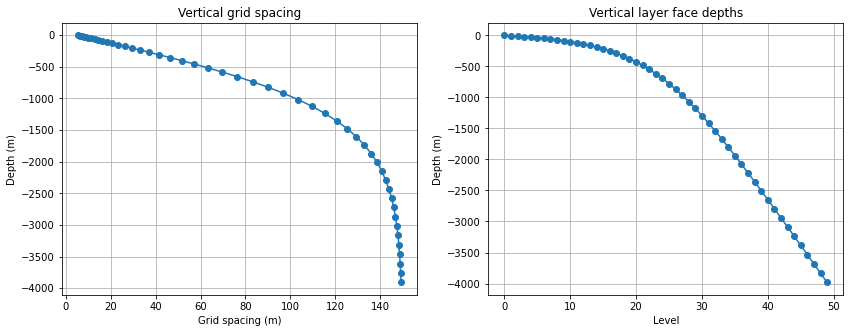

In [3]:
# plot vertical grid spacing

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(DRF[:,0,0], RC[:,0,0], '-o')
plt.grid()
plt.title('Vertical grid spacing')
plt.xlabel('Grid spacing (m)')
plt.ylabel('Depth (m)')
plt.subplot(1,2,2)
plt.plot(RF[:,0,0], '-o')
plt.grid()
plt.title('Vertical layer face depths')
plt.xlabel('Level')
plt.ylabel('Depth (m)'); 


The bathymetry consists of a reentrant channel in the x-coordinate, including a deep ridge running N-S
with a sloping notch cut out in the middle. A wall ("land cells") exists at the southernmost row of 
the domain (row of wall cells not plotted in figure below).

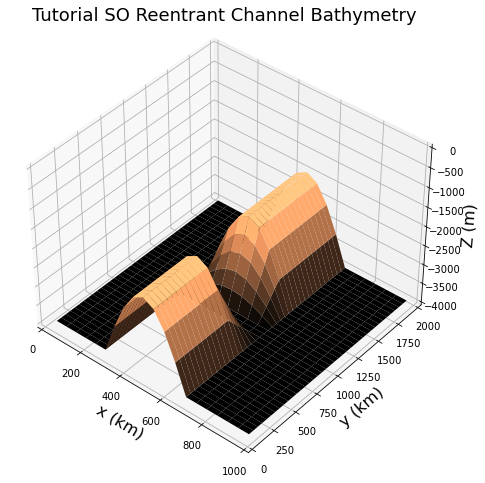

In [4]:
#plot bathymetry as 3D surface plot, as shown in fig 4.10

bathy = np.fromfile(path + 'bathy.50km.bin', dtype='>f4')
bathy.shape = (Ny,Nx)
plt.figure(figsize=(10,8)) 
ax = plt.axes(projection='3d')
ax.plot_surface(XC[1:,:]/1000, YC[1:,:]/1000, bathy[1:,:], cmap='copper', edgecolor='none');
ax.view_init(40, -50)
ax.set_zlim(-4000,0)
ax.set_zlabel('Z (m)', fontsize=16)
ax.set_title('Tutorial SO Reentrant Channel Bathymetry', fontsize=18)
plt.xlabel('x (km)',fontsize=16); plt.ylabel('y (km)', fontsize=16)
plt.xlim(0,1000)
plt.ylim(0,2000);


In the surface layer, temperature is restored to a linear profile:


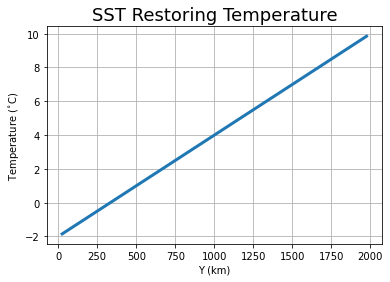

In [5]:
# SST linear restoring temp

sst_relax = np.fromfile(path + 'SST_relax.50km.bin', dtype='>f4')
sst_relax.shape = (Ny,Nx)
plt.plot(YC[:,0]/1000, sst_relax[:,0], linewidth=3)
plt.grid()
plt.ylabel('Temperature ($^{\circ}$C)')
plt.xlabel('Y (km)')
plt.title('SST Restoring Temperature', fontsize=18);


The vertical profile of initial conditions in temperature at the northern and southern ends of the domain is shown.
Note that during the run, temperature is restored back to these conditions along the northen boundary.

The vertical profile is specified as follows (where $T_{max}$ is the restoring SST(y)
and $T_{min}$ = -2 $^{\circ}$C), and $H$ is the maximum ocean depth):


$$ T(z) = (T_{max} - T_{min}) \frac{exp(z/h) - exp(-H/h)}{1 - exp(-H/h)} + T_{min} $$ 

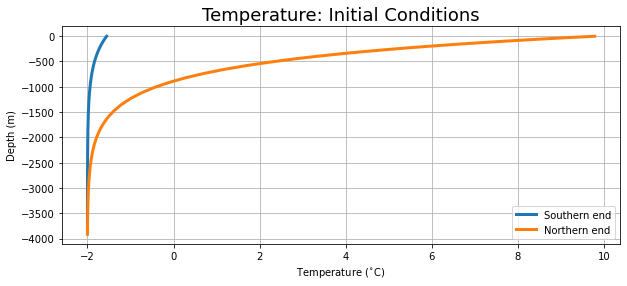

In [6]:
# Temperature initial conditions, as shown in  fig 4.11

T_3D = np.fromfile(path + 'temperature.50km.bin', dtype='>f4')
T_3D.shape = (Nr,Ny,Nx)
plt.figure(figsize=(10,4))
plt.plot(T_3D[:,1,1], RC[:,0,0], linewidth=3, label='Southern end')
plt.plot(T_3D[:,-1,1], RC[:,0,0], linewidth=3, label='Northern end')
plt.legend()
plt.grid()
plt.xlabel('Temperature ($^{\circ}$C)')
plt.ylabel('Depth (m)')
plt.title('Temperature: Initial Conditions', fontsize=18);


The "mask" used for 3D temperature restoring (`pkg/rbcs`) is plotted below (showing YZ plane). Note that we are not
using `pkg/rbcs` in the surface layer (`T_msk[0,:,:]=0`), instead the SST is restored through
options set in file `data`. Mask values range between 0 and 1, with 0=no restoring, 1=full restoring with timescale prescibed in `data.rbcs`, with fractional strength in between.

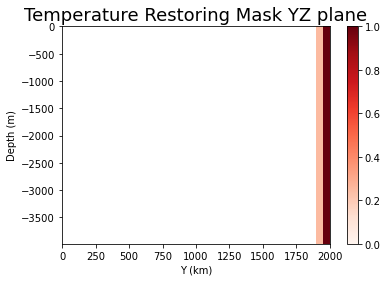

In [7]:
# restoring mask in yz plane, showing restoring along northern boundary

T_msk = np.fromfile(path + 'T_relax_mask.50km.bin',dtype='>f4')
T_msk.shape = (Nr,Ny,Nx)
# just shade where restoring occurs (non-zero mask), white figure background = no restoring
plt.pcolormesh(Yp1/1000, RF, np.ma.array(T_msk[:,:,0], mask=(T_msk[:,:,0]==0)), cmap='Reds', vmin=0)
plt.title('Temperature Restoring Mask YZ plane', fontsize=18)
plt.colorbar()
plt.xlabel('Y (km)')
plt.ylabel('Depth (m)');


Applied surface wind stress in the x-direction

$$ \tau_x(y) = \tau_{0}\sin \left( \frac{y}{2 L_y} \pi \right) $$

is as follows:

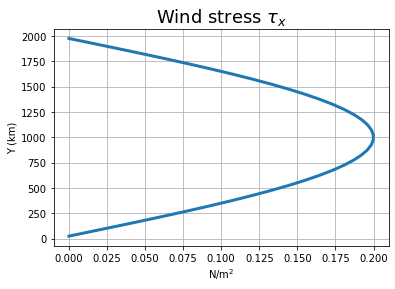

In [8]:
# wind stress profile

taux = np.fromfile(path + 'zonal_wind.50km.bin',dtype='>f4')
taux.shape = (Ny,Nx)
plt.plot(taux[:,0], YC[:,0]/1000, linewidth=3)
plt.grid()
plt.xlabel('N/m$^2$')
plt.ylabel('Y (km)')
plt.title(r'Wind stress $\tau_x$',fontsize=18);


# Load diagnostic data

Here we have separate directories labelled ``run`` and ``run_noGM`` and we load up 
sets of statistical diagnostics and  diagnostics of (annual mean) year 30 data (corresponding to iteration number 933120) from each.

Diagnostics output (as specified in ``data.diagnostics``) consists of:

  state[0,1,2,3,4] = ``THETA``, ``VVEL``, ``UVEL``, ``WVEL``, ``CONVADJ`` <br>
  diag2D[0,1,2] = ``TRELAX``, ``MXDEPTH``, ``ETAN`` <br>
  gm_diags[0,1] = ``GM_PsiX``, ``GM_PsiY`` <br>
  laydiag[0,1,2] = ``LaVH1TH``, ``LaHs1TH``, ``LaVa1TH`` <br>
  
Statistical diagnostics are loaded into a dictionary-like object which can be accessed
by key ``THETA`` or ``TRELAX``: 
 - statdiags_2D is dimensioned (iter, [ave,std,min,max,vol])
 - statdiags_bylev is dimensioned (iter, kLev, [ave,std,min,max,vol]).

See output file ``available_diagnostics.log`` for a description of these diagnostics, including units.


In [9]:
# choose iteration number corresponding to year 30 (annual average)

iter = 933120

state_wGM = mds.rdmds(path + 'Diags/state', iter)
diag2D_wGM = mds.rdmds(path + 'Diags/2D_diags', iter)
gm_diags = mds.rdmds(path + 'Diags/GM_diags', iter)
laydiag_wGM = mds.rdmds(path + 'Diags/layDiag', iter)
stdiags_bylev_wGM,stdiags_2D_wGM,iters = diagnostics.readstats(path + 'dynStDiag.0000000000.txt')

In [10]:
path = '../run_noGM/'     # switch path to load output data from run without GM
state_woGM = mds.rdmds(path + 'Diags/state', iter)
diag2D_woGM = mds.rdmds(path + 'Diags/2D_diags', iter)
laydiag_woGM = mds.rdmds(path + 'Diags/layDiag', iter)
stdiags_bylev_woGM,stdiags_2D_woGM,iters = diagnostics.readstats(path + 'dynStDiag.0000000000.txt')


# Statistical Diagnostics Time Series

First we'll examine the time series of net surface heat flux into the ocean
(here, diagnostic ``TRELAX``, from temperature relaxation),
showing both w/GM and w/o GM
runs on the same plot. As an equilibrium is approached, these series level off to a constant non-zero value because
of net heat loss at the sponge layer northern boundary.

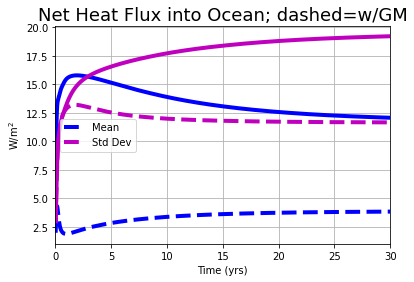

In [11]:
#statistical diagnostics - TRELAX

# note we have to do a conversion of iteration number into time units, 
# using timestep deltaT=1000 sec (and convert seconds -> years)

deltaT = 1000
plt.plot(np.array(iters['TRELAX'][:]) * deltaT/86400/360, stdiags_2D_wGM['TRELAX'][:,0],
                  'b--', linewidth=4, label='Mean')
plt.grid()
plt.plot(np.array(iters['TRELAX'][:]) * deltaT/86400/360, stdiags_2D_wGM['TRELAX'][:,1], 
                  'm--', linewidth=4, label='Std Dev')
plt.legend()
plt.plot(np.array(iters['TRELAX'][:]) * deltaT/86400/360, stdiags_2D_woGM['TRELAX'][:,0],
                  'b', linewidth=4)
plt.plot(np.array(iters['TRELAX'][:]) * deltaT/86400/360, stdiags_2D_woGM['TRELAX'][:,1], 
                  'm', linewidth=4)
plt.xlim(0,30)
plt.xlabel('Time (yrs)')
plt.ylabel('W/m$^2$')
plt.title('Net Heat Flux into Ocean; dashed=w/GM', fontsize=18);


Similary, we plot a time series of (global mean) ``THETA`` at the surface, mid-depth, and abyss,
which appear to show similar equilibration at 30 years except for
some continued warming at depth in the w/o GM run:

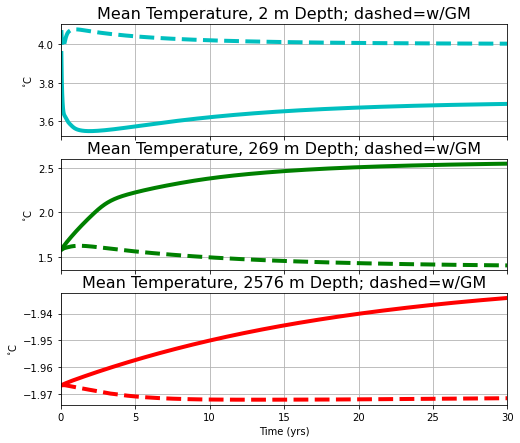

In [12]:
#statistical diagnostics - THETA

# choose depths for time series plots of THETA 
kloc1 = 0    # MITgcm k=1 surface
kloc2 = 16   # MITgcm k=17 270m
kloc3 = 39   # MITgcm k=40 2577m depth

fig, axarr = plt.subplots(3, 1, sharex=True, figsize=(8,7))

axarr[0].plot(np.array(iters['THETA'][:]) * deltaT/86400/360, stdiags_bylev_wGM['THETA'][:,kloc1,0],
                       'c--', linewidth=4)
axarr[0].plot(np.array(iters['THETA'][:]) * deltaT/86400/360, stdiags_bylev_woGM['THETA'][:,kloc1,0],
                       'c', linewidth=4)
axarr[0].grid()
axarr[0].set_ylabel('$^{\circ}$C')
axarr[0].set_title('Mean Temperature, %d m Depth; dashed=w/GM' %np.abs(RC[kloc1]), fontsize=16)
axarr[1].plot(np.array(iters['THETA'][:]) * deltaT/86400/360, stdiags_bylev_wGM['THETA'][:,kloc2,0],
                       'g--', linewidth=4)
axarr[1].plot(np.array(iters['THETA'][:]) * deltaT/86400/360, stdiags_bylev_woGM['THETA'][:,kloc2,0],
                       'g', linewidth=4);
axarr[1].set_title('Mean Temperature, %d m Depth; dashed=w/GM' %np.abs(RC[kloc2]), fontsize=16)
axarr[1].grid()
axarr[1].set_ylabel('$^{\circ}$C')
axarr[2].plot(np.array(iters['THETA'][:]) * deltaT/86400/360, stdiags_bylev_wGM['THETA'][:,kloc3,0],
                       'r--', linewidth=4)
axarr[2].plot(np.array(iters['THETA'][:]) * deltaT/86400/360, stdiags_bylev_woGM['THETA'][:,kloc3,0],
                       'r', linewidth=4)
axarr[2].grid()
axarr[2].set_ylabel('$^{\circ}$C')
axarr[2].set_title('Mean Temperature, %d m Depth; dashed=w/GM' %np.abs(RC[kloc3]), fontsize=16);
axarr[2].set_xlim(0,30)
axarr[2].set_xlabel('Time (yrs)');


# Data.diagnostics output, year 30 annual mean

To look at temperature structure in the yz plane,
we compute and plot zonal mean temperature and zonal mean mixed layer depth. We use the grid variable
``hFacC``, which contains the partial cell fraction, to compute a weighted mean.

To plot, we use ``contourf`` to shade zonal mean temperature; unless we take extra steps,
the plot will include a thin strip of white
(or background color) space between land points and valid data at ``YC``, ``RC`` points. To avoid this,
we create a "padded" copy (``zmTpad``) of the zonal mean temperature (``zmT``) data with an extra row and column,
and do the following:

  - duplicate the ``zmT`` data adjacent to the southern wall onto these "land" points
  - copy the northernmost ``zmT`` data onto the extra column (at the north)
  - copy the bottommost ``zmT`` data onto the extra row (at the bottom)
  - we plot a gray rectangle over the southern wall points to properly show the land location

Finally, when we call ``contourf``, we need to augment the both the ``YC`` and ``RC`` vectors
with an additional gridpoint location.

Note that we did NOT "pad" the top zmT row which is located at ``RC[0]``= -2.7 m
(whereas our plot extends to the surface).
Given that our vertical axis ranges over 2500 m depth, this 2.7 m worth of white space
is not noticeable -- but it is obvious if one limits the plot
to the top 100 m, for example, in which case repeating the padding procedure at the
surface (i.e. augmenting a surface value
point at 0 m depth) might be worthwhile.

This may seem like a lot of extra effort when ``pcolormesh`` will avoid the white space problem, whether you pass
``pcolormesh`` with ``Yp1``, ``RF`` sized dimensions or ``YC``, ``RC``
dimensions with ``shading='auto'``. Indeed, it is. However
``pcolormesh`` will generally give you a plot that looks pixelated whereas a ``contourf`` plot will render smooth
gradations, depending on your choice of contour interval, often permitting better visualization of results.


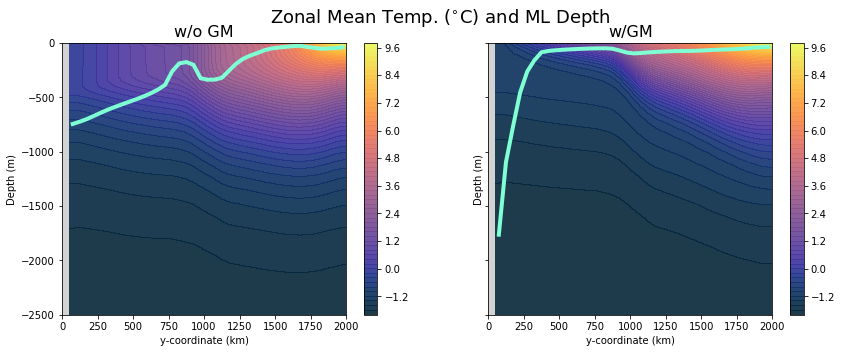

In [13]:
# compute and compare zonal mean temperature and mixed layer depth

# compute zonal mean T, weight by partial cell factor
# using Cartesian grid (uniform horiz. spacing), all grid cells(k) have same volume
# using a more complex grid, one might need to weight by cell area RAC
# when computing area-weighted quantities

zmT_woGM = np.ma.average(state_woGM[0,:,:,:], axis=2, weights=hFacC)
zmT_wGM = np.ma.average(state_wGM[0,:,:,:], axis=2, weights=hFacC)

# to pad zmT with temp values on land points, to avoid white space in contourf plot e.g.
# between y=50km and first YC point with data, 75km

zmTpad_woGM = np.zeros((RF.size, Ny+1))
zmTpad_woGM[:-1,:-1] = zmT_woGM        # augment zmT shape (+1,+1)
zmTpad_woGM[:-1,0] = zmT_woGM[:,1]     # copy zmT values onto southern land column
zmTpad_woGM[:-1,-1] = zmT_woGM[:,-1]
zmTpad_woGM[-1,:] = zmTpad_woGM[-2,:]  # copy onto added northern col. and bottom row
zmTpad_wGM = np.zeros((RF.size, Ny+1))
zmTpad_wGM[:-1,:-1] = zmT_wGM          # repeat padding procedure with GM run data
zmTpad_wGM[:-1,0] = zmT_wGM[:,1]
zmTpad_wGM[:-1,-1] = zmT_wGM[:,-1]
zmTpad_wGM[-1,:] = zmTpad_wGM[-2,:]

# make the plots
# the plot in the users manual was done using MATLAB parula colormap
# (which Mathworks arguably claim they have copyrighted, albeit posted here:
# https://stackoverflow.com/questions/34859628/has-someone-made-the-parula-colormap-in-matplotlib )
# instead we will use cmocean_v2 thermal, which out-of-the-box is a bit dark, so we lighten a bit.

light_thermal = cmocean.tools.lighten(cmocean.cm.thermal, 0.90)
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(14,5))

im = axarr[0].contourf(np.append(YC[:,0], YC[-1,0] + DYC[-1,0])/1000,
                       np.append(RC[:,0,0], RC[-1,0,0] + DRC[-1,0,0]),
                       zmTpad_woGM, np.arange(-2,10,.2), cmap=light_thermal)
plt.colorbar(im, ax =axarr[0])
im = axarr[1].contourf(np.append(YC[:,0], YC[-1,0] + DYC[-1,0])/1000,
                       np.append(RC[:,0,0], RC[-1,0,0] + DRC[-1,0,0]),
                       zmTpad_wGM, np.arange(-2,10,.2), cmap=light_thermal)
plt.colorbar(im, ax = axarr[1])
axarr[0].set_xlim(0,2000)
axarr[1].set_xlim(0,2000)
axarr[0].set_ylim(-2500,0)
axarr[0].add_patch(Rectangle((0, RF[-1,0,0]), 50, -RF[-1,0,0], facecolor='lightgray'))
axarr[1].add_patch(Rectangle((0, RF[-1,0,0]), 50, -RF[-1,0,0], facecolor='lightgray'))
axarr[0].set_xlabel('y-coordinate (km)')
axarr[1].set_xlabel('y-coordinate (km)')
axarr[0].set_ylabel('Depth (m)')
axarr[1].set_ylabel('Depth (m)')

# compute zonal mean ML depth and add to the plots
zmML_woGM = np.ma.average(diag2D_woGM[1,:,:], axis=1, weights=hFacC[0,:,:])
zmML_wGM = np.ma.average(diag2D_wGM[1,:,:], axis=1, weights=hFacC[0,:,:])
axarr[0].plot(YC[1:,0]/1000, -zmML_woGM[1:], linewidth=4, color='aquamarine')
axarr[1].plot(YC[1:,0]/1000, -zmML_wGM[1:], linewidth=4, color='aquamarine')

axarr[0].set_title('w/o GM', fontsize=16)
axarr[1].set_title('w/GM', fontsize=16)
fig.suptitle('Zonal Mean Temp. ($^{\circ}$C) and ML Depth',fontsize=18);


Next, we plot the convective adjustment index (``CONVADJ``) fairly close to the surface
(here, we choose 92 m depth).
Typically, it is useful to know where
convective mixing is occuring (and how often; 0=never convecting, 1= always convecting), and in this
setup we see a big difference in mixed layer depths w/ and w/o GM. This is also readily
apparent in the mixed layer depth plotted above.

For this plot ``pcolormesh`` is perfectly acceptable. For clarity we again show the southern wall as a gray
rectangle patch.

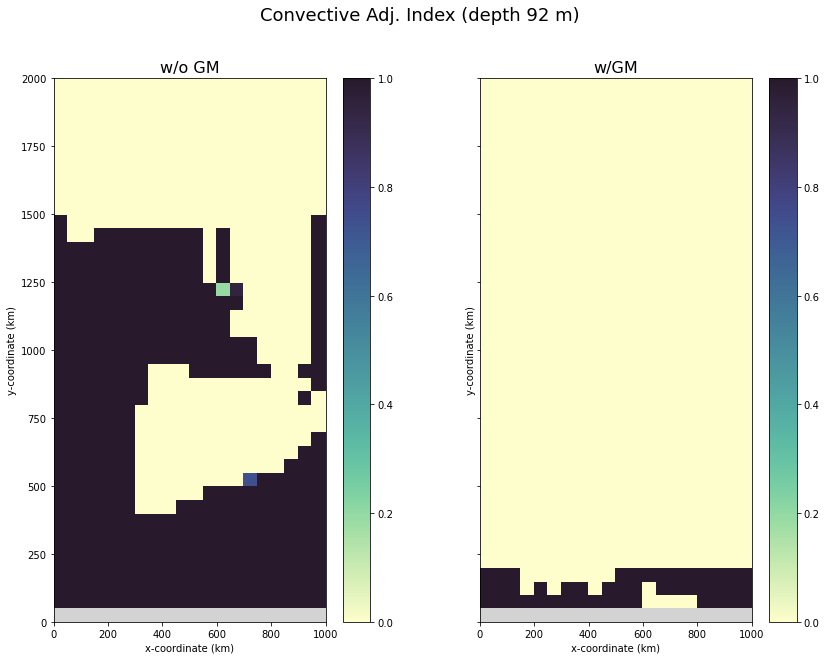

In [14]:
# compare convective adjustment index

#plot at MITgcm k=10 which is 92 m depth
klev = 9

# make plots; note here we use pcolormesh passed with size XC,YC
# and let matplotlib figure out the XG,YG locations
# uses cmocean_v2 colormap 'deep'

fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(14,10))

im = axarr[0].pcolormesh(XC/1000, YC/1000, state_woGM[4,klev,:,:],
                         cmap=cmocean.cm.deep, shading='auto')
plt.colorbar(im, ax=axarr[0])
axarr[0].add_patch(Rectangle((0, 0), 1000, 50, facecolor='lightgray'))
axarr[0].set_xlabel('x-coordinate (km)')
axarr[0].set_ylabel('y-coordinate (km)')
axarr[0].set_aspect('equal')
im = axarr[1].pcolormesh(XC/1000, YC/1000, state_wGM[4,klev,:,:],
                         cmap=cmocean.cm.deep, shading='auto')
plt.colorbar(im, ax =axarr[1])
axarr[1].add_patch(Rectangle((0, 0), 1000, 50, facecolor='lightgray'));
axarr[1].set_aspect('equal')
axarr[1].set_xlabel('x-coordinate (km)')
axarr[1].set_ylabel('y-coordinate (km)')

axarr[0].set_title('w/o GM', fontsize=16)
axarr[1].set_title('w/GM', fontsize=16)
fig.suptitle('Convective Adj. Index (depth %d m)' %np.abs(RC[klev]), fontsize=18);


Let's examine the barotropic streamfunction to assess the strength of the zonal current. Similar to the
computation in tutorial Baroclinic Ocean Gyre, first compute a depth-integrated
zonal transport $U_{bt}$ (i.e., $u$ multiplied by the vertical cell depth ``DRF``).
Note we use ``np.pad`` option ``'wrap'`` with specification ``[(0,0),(0,0),(0,1)]`` which will duplicate the upper end
of the **third** axis (i.e., the x-axis) with values taken from the lower end. It is necessary to wrap the
u-velocity entering the domain from the west to the domain eastern edge, in order to plot a contour of
streamfunction over the full domain. We also weight the u-velocity by ``hFacW``,
the partial cell factor at the western
edge of each gridcell; this is the portion of the gridcell edge open to flow. The streamfunction $\Psi_{bt}$
is then formulated as follows:

$$U_{bt} = - \frac{\partial \Psi_{bt}}{\partial y}, \phantom{WW} V_{bt} = \frac{\partial \Psi_{bt}}{\partial x}$$

which we compute by multiplying $U_{bt}$ by the length of the western gridcell edge (``DYG``) and doing
a cumulative sum in the north-south direction. When $\Psi_{bt}$ is plotted we add a row of zeros (i.e., no flow)
at the southern boundary.


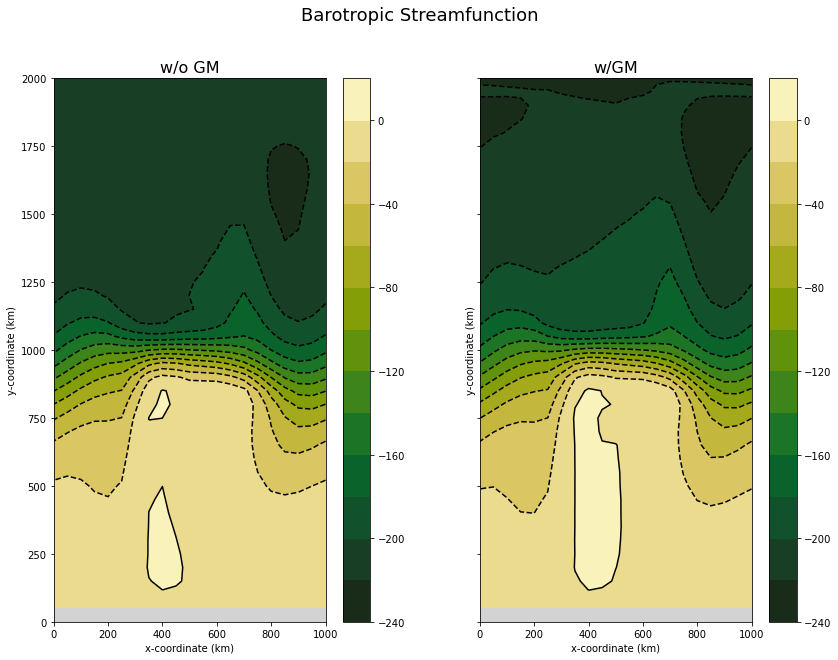

In [15]:
# barotropic streamfunction computation and comparison

ubt_woGM = ((np.pad(state_woGM[2,:,:,:], [(0,0),(0,0),(0,1)], 'wrap') * 
             np.pad(hFacW, [(0,0),(0,0),(0,1)], 'wrap')) * DRF).sum(0)       # depth-integrated uvel
psi_woGM = (np.pad(DYG,[(0,0),(0,1)], 'wrap') * (-ubt_woGM)).cumsum(0) / 1E6 # cumsum in N-S direction

ubt_wGM = ((np.pad(state_wGM[2,:,:,:],[(0,0),(0,0),(0,1)], 'wrap')  * 
            np.pad(hFacW, [(0,0),(0,0),(0,1)], 'wrap')) * DRF).sum(0)        # repeat calculation w/GM data
psi_wGM = (np.pad(DYG,[(0,0),(0,1)], 'wrap') * (-ubt_wGM)).cumsum(0) / 1E6

# make plots
# use cmocean_v2 colormap 'speed_r'

fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(14,10))

im=axarr[0].contourf(Xp1/1000, Yp1/1000, np.concatenate((np.zeros((Nx+1,1)).T, psi_woGM)),
                     levels=np.arange(-240,40,20), cmap=cmocean.cm.speed_r)
plt.colorbar(im, ax=axarr[0])
axarr[0].contour(Xp1/1000, Yp1/1000, np.concatenate((np.zeros((Nx+1,1)).T, psi_woGM)),
                 levels=np.arange(-240,40,20), colors='k')
axarr[0].add_patch(Rectangle((0, 0), 1000, 50, facecolor='lightgray'))
axarr[0].set_xlabel('x-coordinate (km)')
axarr[0].set_ylabel('y-coordinate (km)')
axarr[0].set_aspect('equal')

im = axarr[1].contourf(Xp1/1000, Yp1/1000, np.concatenate((np.zeros((Nx+1,1)).T, psi_wGM)),
                       levels=np.arange(-240,40,20), cmap=cmocean.cm.speed_r)
plt.colorbar(im, ax=axarr[1])
axarr[1].contour(Xp1/1000, Yp1/1000, np.concatenate((np.zeros((Nx+1,1)).T, psi_wGM)),
                 levels=np.arange(-240,40,20), colors='k')
axarr[1].add_patch(Rectangle((0, 0), 1000, 50, facecolor='lightgray'))
axarr[1].set_xlabel('x-coordinate (km)')
axarr[1].set_ylabel('y-coordinate (km)')
axarr[1].set_aspect('equal')

axarr[0].set_title('w/o GM', fontsize=16)
axarr[1].set_title('w/GM', fontsize=16)
fig.suptitle('Barotropic Streamfunction', fontsize=18);


Shifting focus to the overturning circulation in the vertical, we compute and plot the 
meridional overturning circulation (MOC) streamfunction as:

$$\Psi_{moc} = \int_{z}^0 \int_\mathrm{west}^\mathrm{east} v \,\mathrm{d} x \,\mathrm{d} z $$

First, we compute meridional transport: v-velocity multiplied
by the southern edge gridcell length (``DXG``) and gridcell thickness (``DRF``),
weighted by the partial cell factor on this southern edge (``hFacS``), and take its zonal sum (variable ``vzi``).
A row of zeros is added at the bottom; we compute the streamfunction by doing a cumulative sum of ``vzi``
in reverse k-index order. In general, integrating from the bottom upward is preferable, and in fact
avoids issues if a non-linear free surface option is employed.

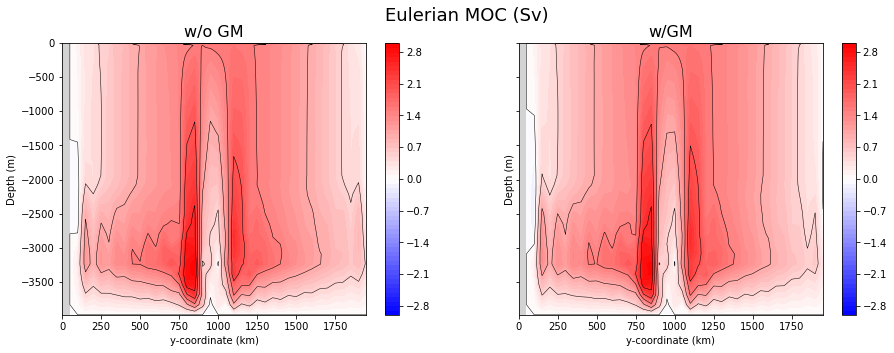

In [16]:
# compute and compare Eulerian MOC

# first, take zonal sum of v*dx*dz, adding a row of zeros at the bottom (RF spans 0:-3982 m dimension 50)
vzi_woGM = np.concatenate((np.sum(state_woGM[1,:,:,:] * DXG * DRF * hFacS, 2), np.zeros((Ny,1)).T))
moc_woGM = -np.cumsum(vzi_woGM[::-1,:],0)[::-1] / 1E6
# repeat w/GM run
vzi_wGM = np.concatenate((np.sum(state_wGM[1,:,:,:] * DXG * DRF * hFacS, 2), np.zeros((Ny,1)).T))
moc_wGM = -np.cumsum(vzi_wGM[::-1,:],0)[::-1] / 1E6

# make plots
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(15,5))

im = axarr[0].contourf(YG[:,0]/1000, RF[:,0,0], moc_woGM, np.arange(-3,3.1,.1), cmap='bwr')
plt.colorbar(im, ax=axarr[0])
axarr[0].contour(YG[:,0]/1000, RF[:,0,0], moc_woGM, np.arange(-3,3.5,.5), colors='k', linewidths=.5)
im = axarr[1].contourf(YG[:,0]/1000, RF[:,0,0], moc_wGM, np.arange(-3,3.1,.1), cmap='bwr')
plt.colorbar(im, ax=axarr[1])
axarr[1].contour(YG[:,0]/1000, RF[:,0,0], moc_wGM, np.arange(-3,3.5,.5), colors='k', linewidths=.5)

axarr[0].set_xlabel('y-coordinate (km)')
axarr[1].set_xlabel('y-coordinate (km)')
axarr[0].set_ylabel('Depth (m)')
axarr[1].set_ylabel('Depth (m)')
axarr[0].add_patch(Rectangle((0, RF[-1,0,0]), 50, -RF[-1,0,0], facecolor='lightgray'))
axarr[1].add_patch(Rectangle((0, RF[-1,0,0]), 50, -RF[-1,0,0], facecolor='lightgray'))

axarr[0].set_title('w/o GM', fontsize=16)
axarr[1].set_title('w/GM', fontsize=16)
fig.suptitle('Eulerian MOC (Sv)', fontsize=18);


The above figures plot the Eulerian MOC, not the residual MOC, the latter being defined as the Eulerian component
plus a contribution from the eddy induced circulation, here formulated as a bolus velocity.
The output diagnostics from ``pkg/gmredi``  include bolus transport streamfunction (below, variable ``psi_bol``, i.e., diagnostic ``GM_PsiY``). Bolus v-velocity is computed as:

$$ v_\mathrm{bolus} = \frac{- \partial \: \mathrm{GM}_{\Psi y}}{\partial z} $$

Conveniently, ``GM_PsiY`` is output at v-velocity points in the horizontal plane, but at the RF
points in the vertical (i.e. vertical cell separation depths, not cell centers);
see sections 2.11.4-2.11.5 in the MITgcm users guide. Thus, computing a
derivative of ``GM_PsiY`` in the vertical (differencing and dividing by ``DRF``) locates
the resulting bolus velocity at the vertical cell center (i.e. ``RC`` depths),
coincident with the ``VVEL`` locations, so they can be added together without any spatial
averaging. Note that ``GM_PsiY`` lacks a value at RF[-1] so we
first augment variable ``psi_bol`` with a plane of zeros at the bottom.
In the calculation of  ``vzi``, the zonally summed,  Eulerian+bolus meridional transport,
it is not necessary to multiply ``bolV`` by ``hFacS`` because ``GM_PsiY`` is a transport diagnostic
and has already been weighted by ``hFacS``.


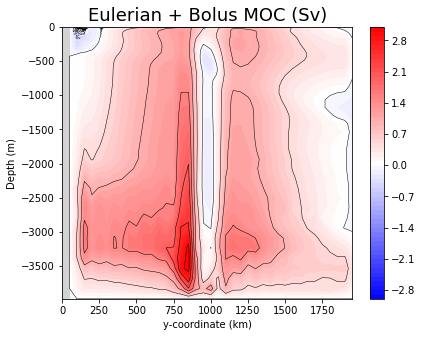

In [17]:
# Compute and plot residual MOC (first computing bolus velocity from GM diagnostics)

psi_bol = np.zeros((RF.size,Ny,Nx))
psi_bol[:-1,:,:] = gm_diags[1,:,:,:] # pad bolus streamfn with zeros at bottom
bolV = (psi_bol[1:,:,:] - psi_bol[:-1,:,:,]) / DRF
# compute moc as before, except adding bolV to v-velocity
vzi = np.concatenate((np.sum((state_wGM[1,:,:,:] * hFacS + bolV) * DXG * DRF,2), np.zeros((Ny,1)).T))
moc_res = -np.cumsum(vzi[::-1,:],0)[::-1] / 1E6

#make plot
plt.figure(figsize=(6.5,5))
plt.contourf(YG[:,0]/1000, RF[:,0,0], moc_res, np.arange(-3,3.2,.1), cmap='bwr')
plt.colorbar()
plt.colorbar(im, ax=axarr[0])
plt.contour(YG[:,0]/1000, RF[:,0,0], moc_res,np.arange(-3,3.5,.5), colors='k', linewidths=.5)
ax = plt.gca()
ax.add_patch(Rectangle((0, RF[-1,0,0]), 50, -RF[-1,0,0], facecolor='lightgray'))

plt.xlabel('y-coordinate (km)')
plt.ylabel('Depth (m)')
plt.title('Eulerian + Bolus MOC (Sv)', fontsize=18);

# Package Layer Diagnostics

### In temperature (density space):

Computing and plotting the MOC in density space is straightforward; ``pkg/layers`` has
already done the heavy lifting for you. While computing the MOC in z-coordinates is a fairly standard diagnostic
for illustrating circulation, examining the overturning in density space is illuminating from a watermass
transformation perspective.
Given ``LaVH1TH``, the meridional mass transport in layers with units m$^2$s$^{-1}$
(using a temperature vertical coordinate to define layers, see Fig. 4.12
in the MITgcm users guide; also note this includes the bolus contribution), we can follow a procedure analogous
to the above (depth-coordinate) MOC computations. Specifically, we take ``LaVH1TH`` (computed
at v-velocity locations), do a cumlative sum in the vertical, multiply by 
the southern edge gridcell length (``DXG``) to get units of m$^3$s$^{-1}$, and then finally
take the zonal sum (variable ``vti``).
One important caveat: in depth space,
k=[0:Nr] proceeds from ocean surface to bottom, whereas
for layers diagnostics k=[0:Nr_layers] proceeds from the ocean bottom to the surface
(this is because vector ``layer_bounds``, which is otherwise analogous to grid variable ``RF``
for the vertical temperature coordinate,
increases from coldest to warmest model temperature). Inserting a row of zeros at the top of ``vti``
specifyies a zero starting value at the ocean bottom (as we did previously).

Because ``pkg/layers`` is essentially doing calculations in a vertical coordinate that is different from
the true model (grid) coordinate, some error is introduced in calculations and the value of streamfunction at
the surface (from a bottom-up ``cumsum``) is not precisely zero. This residual could show up as "noise" contours in
the upper left quadrant of our output plots. To eliminate this, we zero out small positive and 
negative values of ``vti``, here using a threshold of 0.005 Sv, which produces a clean contourf plot.

In interpreting the output plot, the upper contour reflects the surface temperature (i.e., warmest at the north end, coldest at the southern wall). However, given that SST is not zonally uniform,
we have added green dashed lines of maximum and minimum SST to delineate the surface layer.
As such, contours between the SST max and min lines do not reflect overturning in the vertical,
but are indicative of watermass transformation (i.e., surface heat exchange) in the surface layer.

Finally, as noted above, the diagnostic ``LaVH1TH`` includes bolus transport from ``pkg/gmredi``
(if used) so our plot below shows the residual MOC;
in other words, the figure below w/GM is the density coordinate representation of the Eulerian + Bolus
depth MOC shown above. In density space, any circulation that occurs strictly within a density "class", for example
between ``layer_bounds[1]`` and ``layer_bounds[2]`` (temperature -1.75 to -1.5 $^{\circ}$C)
is not represented in the plot below; see additional discussion of these plots in section 4.3.5.1.

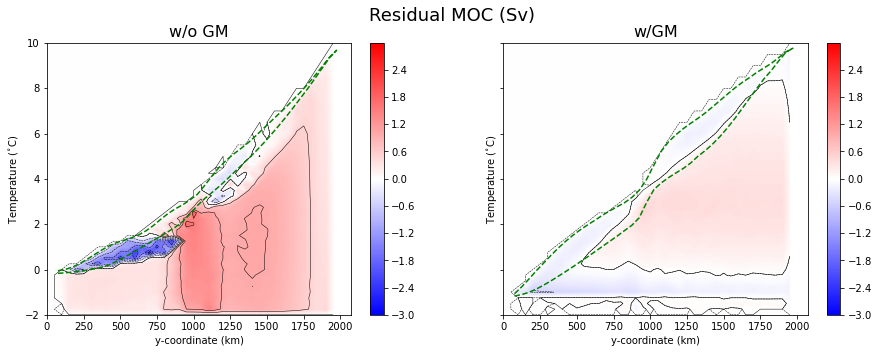

In [18]:
# Compute and plot residual MOC from package layer diagnostics, in density space

vti_woGM = -np.concatenate((np.zeros((Ny,1)).T, (laydiag_woGM[0,:,:,:].cumsum(0)*DXG).sum(2))) / 1E6
# due to small error in calculation, at the ocean top the value is not precisely zero
# force small residual -> 0 to make a cleaner plot
vti_woGM[abs(vti_woGM) < .005] = 0
vti_wGM = -np.concatenate((np.zeros((Ny,1)).T, (laydiag_wGM[0,:,:,:].cumsum(0)*DXG).sum(2))) / 1E6
vti_wGM[abs(vti_wGM) < .005] = 0
 
# make plots
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(15,5))

im = axarr[0].contourf(YG[:,0]/1000, layer_bounds, vti_woGM, np.arange(-3,3,.01), cmap='bwr')
plt.colorbar(im, ax=axarr[0])
axarr[0].contour(YG[:,0]/1000, layer_bounds, vti_woGM, np.arange(-3,3,.5), linewidths=0.5, colors='k')
# trick matplotlib to get it to draw top 0 contour
axarr[0].contour(YG[:,0]/1000, layer_bounds, vti_woGM,[-0.00001], linewidths=0.5, colors='k') 
axarr[0].plot(YC[1:,0]/1000, state_woGM[0,0,1:,:].max(1), 'g--') # plot maximum SST(y) 
axarr[0].plot(YC[1:,0]/1000, state_woGM[0,0,1:,:].min(1), 'g--') # and minimum SST(y) to delineate the surface layer
# in an eddy-resolving run, you need to dump data more frequently to obtain
# reasonable estimates for SST max, min (e.g. daily, not monthly, dumps)

im = axarr[1].contourf(YG[:,0]/1000, layer_bounds, vti_wGM, np.arange(-3,3,.01), cmap='bwr')
plt.colorbar(im, ax=axarr[1])
axarr[1].contour(YG[:,0]/1000, layer_bounds,vti_wGM, np.arange(-3,3,.5), linewidths=0.5, colors='k')
axarr[1].contour(YG[:,0]/1000, layer_bounds, vti_wGM, [-0.00001], linewidths=0.5, colors='k') 
axarr[1].plot(YC[1:,0]/1000, state_wGM[0,0,1:,:].max(1), 'g--')
axarr[1].plot(YC[1:,0]/1000, state_wGM[0,0,1:,:].min(1), 'g--')

axarr[0].set_xlabel('y-coordinate (km)')
axarr[0].set_ylabel('Temperature ($^{\circ}$C)')
axarr[1].set_xlabel('y-coordinate (km)')
axarr[1].set_ylabel('Temperature ($^{\circ}$C)')
axarr[0].set_title('w/o GM', fontsize=16)
axarr[1].set_title('w/GM', fontsize=16)
fig.suptitle('Residual MOC (Sv)', fontsize=18);


### Converted back to depth (z) space:

While the merits of visualizing the overturning in density space is apparent, these plots can be
a challenge to interpret in terms of the true spatial circulation. Moreover, it is often useful
to compute and compare the depth-coordinate rendering of the above plots with our earlier
z-coordinate MOC plots; the former will eliminate any adiabatic circulation as compared to the latter.

For this calculation, we will first calculate the z-location of layer depths (``csum_th``)
through a surface-to-bottom cumulative sum of diagnostic ``LaHs1TH`` (note, this is the layer thickness
on the southern face of each cell, corresponding spatially with diagnostic ``LAVH1TH``).
It is again necessary to first augment the result with a row
of zeros, corresponding to the surface at z=0. Then we take a zonal mean. To calculate
the layer transports (``csum_tr``), the computation is the same as above (using ``LAVH1TH``)
except for reversing the
k-index on the ``cumsum`` given for this calculation we proceed from the surface downward.

To assess the extent to which interior circulation is adiabatic, also plotted are
zonal mean temperature contours, using variable ``zmT`` computed earlier in this notebook. Not surprisingly,
we see a big difference between the run without GM (which includes large parameterized horizontal mixing)
versus the run with GM.

Note that using a zonal mean to compute layer depths in the YZ plane may be problematic in a solution
where layer depths vary significantly in a zonal band, e.g., in a setup with  more complex topography,
if using a non-linear
equation of state, and/or which includes marginal seas.

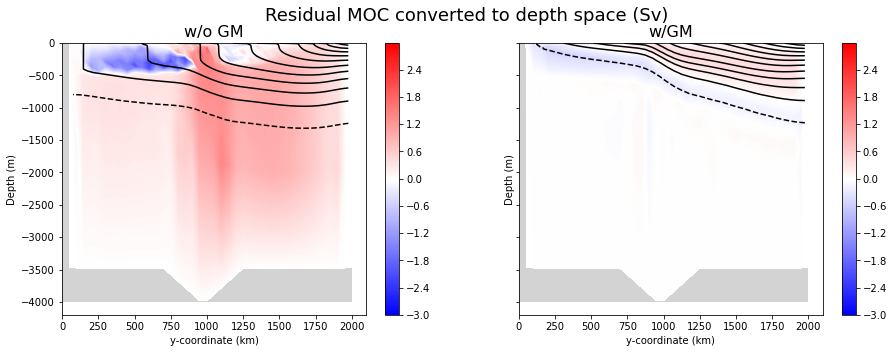

In [19]:
#residual MOC from layers, converted back into depth coordinates

# calculate layer depths through cumsum of layer thickness, surface to bottom
# need to reverse k-index on cumsum given k[0] is coldest temperature (ocean bottom)
csum_th_woGM = -np.concatenate((np.zeros((40,1)).T, laydiag_woGM[1,::-1,:,:].cumsum(0).mean(2)))
# then cumsum the layer transports from ocean surface downward, multiply by DXG, and integrate zonally
csum_tr_woGM = np.concatenate((np.zeros((40,1)).T, (laydiag_woGM[0,::-1,:,:].cumsum(0)*DXG).sum(2))) / 1E6
# then this can be plotted specifying 2D arrays for x-axis (Y-coor) and y-axis (layer z-locations)

# repeat calculation for run w/GM
csum_th_wGM = -np.concatenate((np.zeros((40,1)).T, laydiag_wGM[1,::-1,:,:].cumsum(0).mean(2)))
csum_tr_wGM = np.concatenate((np.zeros((40,1)).T, (laydiag_wGM[0,::-1,:,:].cumsum(0)*DXG).sum(2))) / 1E6

Y = np.tile(YG[:,0]/1000, (38, 1))  # this is basically the Y output of a meshgrid(layer_bounds,YG[:,0])

# make plots
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(15,5))

axarr[0].add_patch(Rectangle((0, -4000), 2000, 520.5, facecolor='lightgray'))
im = axarr[0].contourf(Y, csum_th_woGM, csum_tr_woGM,np.arange(-3,3,.01), cmap='bwr', zorder=2)
plt.colorbar(im, ax=axarr[0])
# use zonal mean temperature variable zmT computed above
axarr[0].contour(YC[:,0]/1000,RC[:,0,0], zmT_woGM, np.arange(-2,10,1), colors='k')
axarr[0].add_patch(Rectangle((0, -4000), 50, 4000, facecolor='lightgray'))

axarr[1].add_patch(Rectangle((0, -4000), 2000, 520.5, facecolor='lightgray'))
im = axarr[1].contourf(Y, csum_th_wGM, csum_tr_wGM, np.arange(-3,3,.01), cmap='bwr', zorder=2)
plt.colorbar(im, ax=axarr[1])
axarr[1].contour(YC[:,0]/1000, RC[:,0,0], zmT_wGM, np.arange(-2,10,1), colors='k')
axarr[1].add_patch(Rectangle((0, -4000), 50, 4000, facecolor='lightgray'))

axarr[0].set_xlabel('y-coordinate (km)')
axarr[0].set_ylabel('Depth (m)')
axarr[1].set_xlabel('y-coordinate (km)')
axarr[1].set_ylabel('Depth (m)')
axarr[0].set_title('w/o GM', fontsize=16)
axarr[1].set_title('w/GM', fontsize=16)
fig.suptitle('Residual MOC converted to depth space (Sv)', fontsize=18);
